# Loading Results Back and Obtaining Orbital Solutions  #

by Junellie Gonzalez Quiles for the WFIRST Exoplanet Imaging Tutorial at the Flatiron Institute (2019)

Based on the online documentation for orbitize! and modified for the Data Challenge.

Load up the saved results file.

In [1]:
import orbitize.results
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
from astropy.io import ascii
import orbitize.driver
import orbitize
import astroquery.simbad
import astropy.units as u
%matplotlib inline

planetlet = 'b'

if 'myResults' in locals():
    del myResults # delete existing Results object 
myResults = orbitize.results.Results() # create empty Results object
myResults.load_results('./planet_' + planetlet + '_results.hdf5') # load from file

After we load the data, we obtain the median and the 68% confidence range for all 8 parameters. 

In [2]:
median_values = np.median(myResults.post,axis=0)
lower_bound = np.quantile(myResults.post,0.16,axis = 0)
higher_bound = np.quantile(myResults.post,0.84,axis = 0)
print(median_values)
print(lower_bound)
print(higher_bound)

[2.55130069e+00 6.69377164e-02 7.48146146e-01 3.31902596e+00
 5.31316532e+00 4.08288762e-01 7.24414549e+01 9.72053498e-01]
[2.50225937e+00 2.76928696e-02 6.93928649e-01 1.38416294e+00
 2.35198248e+00 2.85877094e-01 7.23018827e+01 9.21868879e-01]
[ 2.60334117  0.10107914  0.79317696  4.78691893  5.57320213  0.49236819
 72.59002986  1.02754357]


We choose three parameters to plot their histograms.

In [3]:
 # We plot some parameters
sma = myResults.post[:,0]
ecc = myResults.post[:,1]
i = myResults.post[:,2]
params = [sma, ecc, i]

We plot the median and the confidence range values on their histograms.

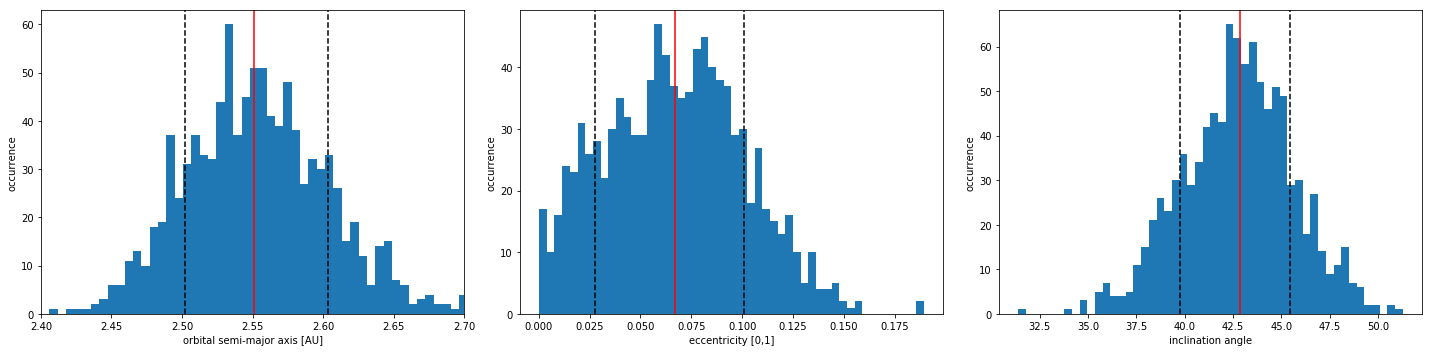

In [4]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(sma, bins=50)
plt.axvline(x=lower_bound[0],color='black',ls='--')
plt.axvline(x=median_values[0],color='red')
plt.axvline(x=higher_bound[0],color='black',ls='--')
plt.xlim([2.4,2.7])
plt.xlabel('orbital semi-major axis [AU]')
plt.ylabel('occurrence')

plt.subplot(132)
plt.hist(ecc, bins=50)
plt.axvline(x=lower_bound[1],color='black',ls='--')
plt.axvline(x=median_values[1],color='red')
plt.axvline(x=higher_bound[1],color='black',ls='--')
plt.xlabel('eccentricity [0,1]')
plt.ylabel('occurrence')

plt.subplot(133)
plt.hist(np.degrees(i), bins=50)
plt.axvline(x=np.degrees(lower_bound[2]),color='black',ls='--')
plt.axvline(x=np.degrees(median_values[2]),color='red')
plt.axvline(x=np.degrees(higher_bound[2]),color='black',ls='--')
plt.xlabel('inclination angle')
plt.ylabel('occurrence')

plt.tight_layout()

# plt.savefig('Histograms_planet_' + planetlet + '.png',dpi=400)
plt.show()

We load the input table using the orbitize.driver.Driver to be able to access the data for the orbits plot.

In [5]:
star_name = "47 UMa"

customSimbad = astroquery.simbad.Simbad()
customSimbad.add_votable_fields('plx','plx_error')
simbad_table = customSimbad.query_object(star_name)
plx = simbad_table['PLX_VALUE'][0]
plx_err = simbad_table['PLX_ERROR'][0]
myDriver = orbitize.driver.Driver('./planet_'+planetlet+'.csv', # path to data file
                                  'OFTI', # name of algorithm for orbit-fitting
                                  1, # number of secondary bodies in system
                                  1, # total system mass [M_sun]
                                  plx, # total parallax of system [mas]
                                  mass_err=0.05, # mass error [M_sun]
                                  plx_err=plx_err) # parallax error [mas]

Converting ra/dec data points in data_table to sep/pa. Original data are stored in input_table.


Now we plot 100 of the orbits randomly chosen from the data.

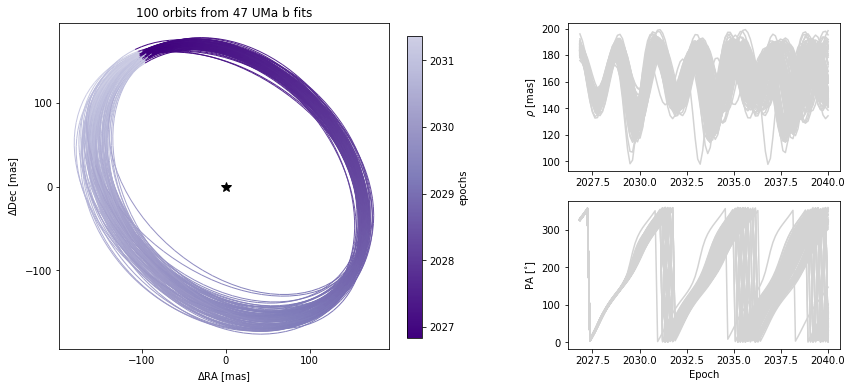

In [6]:
epochs = myDriver.system.data_table['epoch']
orbit_figure = myResults.plot_orbits(
    start_mjd=epochs[0], sep_pa_end_year = 2040) # Minimum MJD for colorbar (here we choose first data epoch
ax_orb, ax_cbar, ax_sep, ax_pa  = orbit_figure.axes

ax_orb.set_title('100 orbits from 47 UMa b fits') # sets title over Axes object only
ax_orb.plot(0,0,marker="*",color='black',markersize=10) #set a star-shaped point where the primary star is located

# plt.savefig('orbits_planet_' + planetlet + '.png',dpi=400)

Save the median and confidence range values as well as the best fit values for all 8 parameters as a csv file.

In [7]:
t = Table()
t['Orbital Parameters'] = Column(['semimajor axis (AU)','eccentricity','inclination (radians)','argument of periastron (radians)','pos angle of nodes (radians)','epoch of periastron passage','parallax','mass'], description='parameters') 
t['Best Fit Orbit'] = Column(myResults.post[np.argmax(myResults.lnlike)])
t['Confidence Range 68%-Lower'] = Column(lower_bound, description='lower bound')
t['Median'] = Column(median_values, description='median')
t['Confidence Range 68%-Upper'] = Column(higher_bound, description='upper bound')

ascii.write(t, 'orbital_solutions_planet_' + planetlet + '.csv', format='csv', overwrite=True) 